In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from scripts.helper_scripts.f1_max_score import count_f1_max

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
train_folder = '/media/ssd-3t-2/amiftakhova/tda_proteins/processed_train/betticurves'
test_folder = '/media/ssd-3t-2/amiftakhova/tda_proteins/processed_test/betticurves'

train_files = [x for x in os.listdir(train_folder) if 'bins80' in x]
test_files = [x for x in os.listdir(test_folder) if 'bins80' in x]

train_features = []
train_features_layer = []
train_labels_mf = []
train_labels_cc = []
train_labels_bp = []
for train_file in train_files:
    try:
        with open(os.path.join(train_folder, train_file), 'rb') as f:
            data = pickle.load(f)
            train_features.append(data['betticurves'].flatten())
            bc = data['betticurves'].reshape((33, 20, -1))
            train_features_layer.append(bc.sum(axis=1).flatten())
            train_labels_mf.append(data['label_MF'])
            train_labels_cc.append(data['label_CC'])
            train_labels_bp.append(data['label_BP'])
    except Exception as e:
        print(e)
        print('File:', train_file)
        print()

train_labels_mf = np.array(train_labels_mf)
train_labels_cc = np.array(train_labels_cc)
train_labels_bp = np.array(train_labels_bp)

test_features = []
test_features_layer = []
test_labels_mf = []
test_labels_cc = []
test_labels_bp = []
for test_file in test_files:
    with open(os.path.join(test_folder, test_file), 'rb') as f:
        data = pickle.load(f)
        test_features.append(data['betticurves'].flatten())
        bc = data['betticurves'].reshape((33, 20, -1))
        test_features_layer.append(bc.sum(axis=1).flatten())
        test_labels_mf.append(data['label_MF'])
        test_labels_cc.append(data['label_CC'])
        test_labels_bp.append(data['label_BP'])
test_labels_mf = np.array(test_labels_mf)
test_labels_cc = np.array(test_labels_cc)
test_labels_bp = np.array(test_labels_bp)

In [3]:
print(len(train_features))
print(len(test_features))

26225
3350


In [12]:
class Baseline(nn.Module):
    def __init__(self, input_size, output_size):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [19]:
def train_epoch(model, train_loader, optimizer, criterion, cuda=True):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        if cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()
    return train_loss / len(train_loader)

def evaluate(model, test_loader, criterion, cuda=True, length=1261):
    model.eval()
    test_loss = 0
    preds = []
    labels_gt = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if cuda:
                inputs = inputs.cuda()
            outputs = model(inputs)
            preds.extend(F.sigmoid(outputs).cpu().numpy())
            labels_gt.extend(labels.cpu().numpy())
    return count_f1_max(np.array(preds).reshape(-1, length), np.array(labels_gt).reshape(-1, length))

def train(model, train_loader, test_loader, optimizer, criterion, epochs, cuda=True, scheduler=None, length=1261):
    losses = []
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, cuda)
        valid_f1 = evaluate(model, test_loader, criterion, cuda, length)
        if scheduler is not None:
            scheduler.step(valid_f1)
        losses.append(train_loss)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid F1: {valid_f1:.4f}')
    return losses

In [20]:
LR = 1e-4
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_features_layer), torch.Tensor(train_labels_mf)), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(test_features_layer), torch.Tensor(test_labels_mf)), batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(test_features_layer), torch.Tensor(test_labels_mf)), batch_size=BATCH_SIZE, shuffle=False)

out_features = len(test_labels_mf[0])
model_mf = Baseline(len(train_features_layer[0]), out_features).cuda()
optimizer = torch.optim.Adam(model_mf.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

losses = train(model_mf, train_loader, valid_loader, optimizer, criterion, epochs=50, length=len(test_labels_mf))

f1_test = evaluate(model_mf, test_loader, criterion, cuda=True, length=len(test_labels_mf))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.6937, Valid F1: 0.1277
Epoch 2/50, Train Loss: 0.5774, Valid F1: 0.1430
Epoch 3/50, Train Loss: 0.3291, Valid F1: 0.1537
Epoch 4/50, Train Loss: 0.1610, Valid F1: 0.1591
Epoch 5/50, Train Loss: 0.0955, Valid F1: 0.1576
Epoch 6/50, Train Loss: 0.0693, Valid F1: 0.1582
Epoch 7/50, Train Loss: 0.0580, Valid F1: 0.1586
Epoch 8/50, Train Loss: 0.0526, Valid F1: 0.1622
Epoch 9/50, Train Loss: 0.0491, Valid F1: 0.1594
Epoch 10/50, Train Loss: 0.0476, Valid F1: 0.1580
Epoch 11/50, Train Loss: 0.0462, Valid F1: 0.1600
Epoch 12/50, Train Loss: 0.0454, Valid F1: 0.1592
Epoch 13/50, Train Loss: 0.0448, Valid F1: 0.1620
Epoch 14/50, Train Loss: 0.0445, Valid F1: 0.1626
Epoch 15/50, Train Loss: 0.0442, Valid F1: 0.1613
Epoch 16/50, Train Loss: 0.0440, Valid F1: 0.1619
Epoch 17/50, Train Loss: 0.0436, Valid F1: 0.1629
Epoch 18/50, Train Loss: 0.0435, Valid F1: 0.1681
Epoch 19/50, Train Loss: 0.0432, Valid F1: 0.1598
Epoch 20/50, Train Loss: 0.0432, Valid F1: 0.1684
Epoch 21/

0.17409886419773102


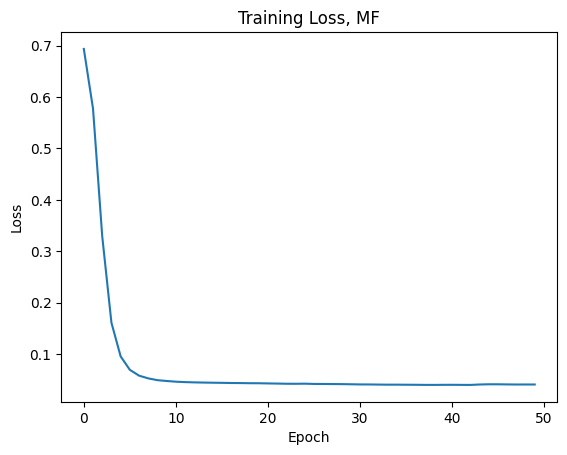

In [21]:
import matplotlib.pyplot as plt

print(f1_test)

plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss, MF')
plt.show()

In [22]:
LR = 1e-4
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_features_layer), torch.Tensor(train_labels_cc)), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(test_features_layer), torch.Tensor(test_labels_cc)), batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(test_features_layer), torch.Tensor(test_labels_cc)), batch_size=BATCH_SIZE, shuffle=False)

out_features = len(test_labels_cc[0])
model_cc = Baseline(len(train_features_layer[0]), out_features).cuda()
optimizer = torch.optim.Adam(model_cc.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

losses = train(model_cc, train_loader, valid_loader, optimizer, criterion, epochs=50, length=len(test_labels_cc))

f1_test = evaluate(model_cc, test_loader, criterion, cuda=True, length=len(test_labels_cc))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.6921, Valid F1: 0.1133
Epoch 2/50, Train Loss: 0.5738, Valid F1: 0.1941
Epoch 3/50, Train Loss: 0.3248, Valid F1: 0.2702
Epoch 4/50, Train Loss: 0.1545, Valid F1: 0.2720
Epoch 5/50, Train Loss: 0.0868, Valid F1: 0.2658
Epoch 6/50, Train Loss: 0.0602, Valid F1: 0.2835
Epoch 7/50, Train Loss: 0.0480, Valid F1: 0.2892
Epoch 8/50, Train Loss: 0.0419, Valid F1: 0.2868
Epoch 9/50, Train Loss: 0.0384, Valid F1: 0.2733
Epoch 10/50, Train Loss: 0.0363, Valid F1: 0.2712
Epoch 11/50, Train Loss: 0.0349, Valid F1: 0.2818
Epoch 12/50, Train Loss: 0.0339, Valid F1: 0.2853
Epoch 13/50, Train Loss: 0.0334, Valid F1: 0.2874
Epoch 14/50, Train Loss: 0.0329, Valid F1: 0.2900
Epoch 15/50, Train Loss: 0.0325, Valid F1: 0.2861
Epoch 16/50, Train Loss: 0.0323, Valid F1: 0.2885
Epoch 17/50, Train Loss: 0.0322, Valid F1: 0.2899
Epoch 18/50, Train Loss: 0.0322, Valid F1: 0.2793
Epoch 19/50, Train Loss: 0.0318, Valid F1: 0.2717
Epoch 20/50, Train Loss: 0.0317, Valid F1: 0.2501
Epoch 21/

0.29175955057144165


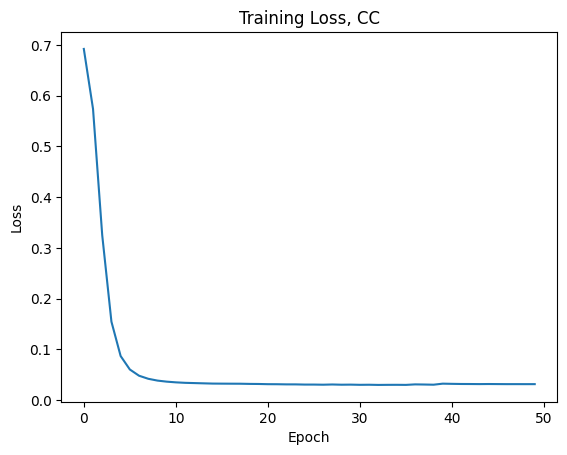

In [23]:
print(f1_test)

plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss, CC')
plt.show()

In [24]:
LR = 1e-4
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_features_layer), torch.Tensor(train_labels_bp)), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(test_features_layer), torch.Tensor(test_labels_bp)), batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(test_features_layer), torch.Tensor(test_labels_bp)), batch_size=BATCH_SIZE, shuffle=False)

out_features = len(test_labels_bp[0])
model_bp = Baseline(len(train_features_layer[0]), out_features).cuda()
optimizer = torch.optim.Adam(model_bp.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

losses = train(model_bp, train_loader, valid_loader, optimizer, criterion, epochs=50, length=len(test_labels_bp))

f1_test = evaluate(model_bp, test_loader, criterion, cuda=True, length=len(test_labels_bp))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.6943, Valid F1: 0.1078
Epoch 2/50, Train Loss: 0.5714, Valid F1: 0.1697
Epoch 3/50, Train Loss: 0.3169, Valid F1: 0.2153
Epoch 4/50, Train Loss: 0.1504, Valid F1: 0.2283
Epoch 5/50, Train Loss: 0.0857, Valid F1: 0.2318
Epoch 6/50, Train Loss: 0.0599, Valid F1: 0.2347
Epoch 7/50, Train Loss: 0.0482, Valid F1: 0.2331
Epoch 8/50, Train Loss: 0.0419, Valid F1: 0.2333
Epoch 9/50, Train Loss: 0.0387, Valid F1: 0.2340
Epoch 10/50, Train Loss: 0.0368, Valid F1: 0.2338
Epoch 11/50, Train Loss: 0.0353, Valid F1: 0.2339
Epoch 12/50, Train Loss: 0.0347, Valid F1: 0.2368
Epoch 13/50, Train Loss: 0.0340, Valid F1: 0.2341
Epoch 14/50, Train Loss: 0.0335, Valid F1: 0.2364
Epoch 15/50, Train Loss: 0.0332, Valid F1: 0.2385
Epoch 16/50, Train Loss: 0.0330, Valid F1: 0.2363
Epoch 17/50, Train Loss: 0.0330, Valid F1: 0.2390
Epoch 18/50, Train Loss: 0.0327, Valid F1: 0.2347
Epoch 19/50, Train Loss: 0.0327, Valid F1: 0.2382
Epoch 20/50, Train Loss: 0.0326, Valid F1: 0.2389
Epoch 21/

0.23657110333442688


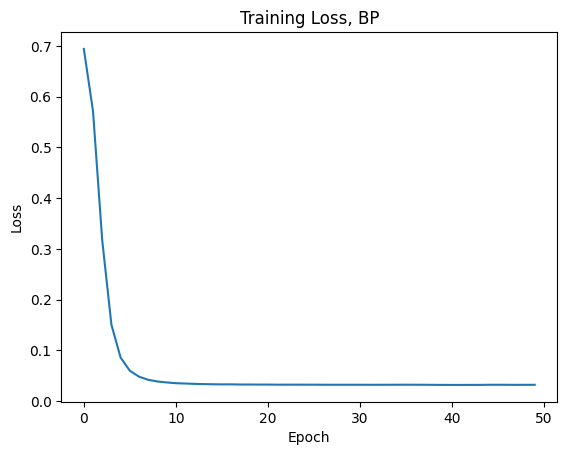

In [25]:
print(f1_test)

plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss, BP')
plt.show()